In [ ]:
def inference(folder_path, gender, age_group, model_path,batch_size=30):
    #age_group은 0 :50, 1:60, 2:70, 3:80, 4:90 <--조심히 사용. age_group 범위는 0~4, gender 0or1
    image_paths = []
    image_numbers = []
    genders = []
    age_groups = []
  # 전역 변수로 full_model을 선언
    global full_model

    # full_model이 로드되어 있지 않다면 모델을 로드하고 전역 변수에 할당
    if 'full_model' not in globals():
        full_model = tf.keras.models.load_model(model_path)

    model_CNN = full_model.pretrained_model.inception_res_partial

    class GradCAM:
        def __init__(self, model, layer_name):
            self.model = model
            self.layer_name = layer_name
            self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

        def compute_heatmap(self, image, class_index):
            with tf.GradientTape() as tape:
                conv_output, predictions = self.gradient_model(image)
                loss = predictions[:, class_index]

            grads = tape.gradient(loss, predictions)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_output = conv_output[0]

            heatmap = conv_output @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)

            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            return heatmap.numpy()

    def load_and_process_image(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (299, 299))
        image = np.expand_dims(image, axis=0)
        return image

    def generate_heatmap_for_patient(patient_folder, model, class_index=1, image_index=18):
        image_path = os.path.join(patient_folder, f"plane{image_index}.png")
        image = load_and_process_image(image_path)

        gradcam = GradCAM(model, 'conv_7b')
        heatmap = gradcam.compute_heatmap(image, class_index)

        heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
        heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
        heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

        return heatmap_color

    def visualize_heatmap(heatmap_color):
        cv2_imshow( heatmap_color)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # 이미지 로드 함수 정의
    def load_image(image_path, gender, age_group, image_number):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)  # PNG 이미지일 경우 channels=3으로 설정
        image = tf.image.resize(image, (299, 299))
        return image, (gender, age_group, image_number)
        #logits outputs
    def calculate_percentage(probabilities):
        neg_percentage = np.mean(probabilities[:, 0]) * 100.0
        pos_percentage = np.mean(probabilities[:, 1]) * 100.0
        return round(neg_percentage, 1), round(pos_percentage, 1)

    # 이미지 폴더에서 이미지 경로 수집
    for i in range(30):
        image_path = os.path.join(folder_path, f"plane{i}.png")
        image_paths.append(image_path)
        image_numbers.append(i)
        genders.append(gender)
        age_groups.append(age_group)

    # 데이터프레임 생성
    data = {
        'image_path': image_paths,
        'gender': genders,
        'age_group': age_groups,
        'image_number': image_numbers
    }
    df = pd.DataFrame(data)

    # 이미지 경로 및 라벨 추출
    image_paths = df['image_path'].values
    gender = tf.cast(df['gender'].values, tf.int64)
    age_group = tf.cast(df['age_group'].values, tf.int64)
    image_number = tf.cast(df['image_number'].values, tf.int64)


    # 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, gender, age_group, image_number))
    # 이미지 로드 및 전처리 적용
    dataset = dataset.map(load_image)
    # 배치 설정
    dataset = dataset.batch(batch_size)

    for images, diagnoses in dataset.take(1):
        logits = model([images,diagnoses])
    neg_percentage, pos_percentage = calculate_percentage(logits)

    print("음성 퍼센트:", neg_percentage)
    print("양성 퍼센트:", pos_percentage)


    # 클래스 인덱스 선택 (음성 또는 양성)
    class_index = 1

    # 이미지 폴더에서 히트맵 생성
    heatmap_color = generate_heatmap_for_patient(folder_path, model_CNN, class_index)

    # 히트맵 이미지 출력
    visualize_heatmap(heatmap_color)

    return heatmap_color,(neg_percentage,neg_percentage)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


음성 퍼센트: 74.0
양성 퍼센트: 26.0


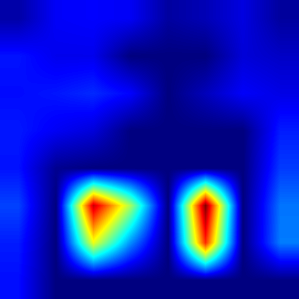

히트맵: [[[168   0   0]
  [168   0   0]
  [168   0   0]
  ...
  [156   0   0]
  [156   0   0]
  [156   0   0]]

 [[168   0   0]
  [168   0   0]
  [168   0   0]
  ...
  [156   0   0]
  [156   0   0]
  [156   0   0]]

 [[168   0   0]
  [168   0   0]
  [168   0   0]
  ...
  [156   0   0]
  [156   0   0]
  [156   0   0]]

 ...

 [[255  12   0]
  [255  12   0]
  [255  12   0]
  ...
  [132   0   0]
  [132   0   0]
  [132   0   0]]

 [[255  12   0]
  [255  12   0]
  [255  12   0]
  ...
  [132   0   0]
  [132   0   0]
  [132   0   0]]

 [[255  12   0]
  [255  12   0]
  [255  12   0]
  ...
  [132   0   0]
  [132   0   0]
  [132   0   0]]]
음성 및 양성 퍼센테지: (74.0, 74.0)


In [ ]:
folder_path = "/content/drive/MyDrive/Dataset/Dementia_sample/Real_data/Mild AD/002_S_0729_110816"
gender = 0
age_group = 0
model_path = "/content/drive/MyDrive/Dataset/inception_resnet"

heatmap_color, percentages = inference(folder_path, gender, age_group, model_path)
print("히트맵:", heatmap_color)
print("음성 및 양성 퍼센테지:", percentages)